In [3]:
import pathlib
import datetime

import pandas as pd
from preprocessing.utils import get_connection, get_crime_codes, get_crime_data

In [6]:
root_dir = pathlib.Path("../data/crime")
keys_dir = root_dir/"keys"
with get_connection() as conn:
    try:
        general_df = pd.read_parquet(keys_dir/"general_key.parquet")
        specific_df = pd.read_parquet(keys_dir/"specific_key.parquet")
        housing_df = pd.read_parquet(keys_dir/"housing_key.parquet")
    except FileNotFoundError:
        general_df, specific_df, housing_df = get_crime_codes(conn)
        general_df.to_parquet(keys_dir/"general_key.parquet")
        specific_df.to_parquet(keys_dir/"specific_key.parquet")
        housing_df.to_parquet(keys_dir/"housing_key.parquet")

    try:
        crime_df = pd.read_parquet(root_dir/"precincts")
        if len(crime_df) == 0:
            raise FileNotFoundError
    except FileNotFoundError:
        crime_df = get_crime_data(conn, 2018, 2_000_000, 0)
        date_time = {
            "crime_close_date":[
                "crime_close_date",
                "crime_close_time"
            ],
            "crime_date":[
                "crime_date",
                "crime_time"
                ],
            "report_date":"report_date",

        }

        for k, f in date_time.items():
            if isinstance(f, list):
                p = crime_df[f[0]]+' '+crime_df[f[1]]
                crime_df.drop(f, axis='columns', inplace=True)
            else:
                p = crime_df[f]
            crime_df[k] = pd.to_datetime(p, errors='coerce')
        crime_df[['latitude','longitude']] = crime_df[['latitude','longitude']].astype('float64')

        crime_df.convert_dtypes(dtype_backend='pyarrow')

        crime_df.to_parquet(root_dir/"precincts", partition_cols=['precinct'])

In [7]:
crime_df.describe()

,report_date,latitude,longitude,crime_close_date,crime_date
count,464138,464138.000000,464138.000000,398734,464100
mean,2018-07-02 04:16:07.925918976,40.735975,-73.925994,2018-06-24 19:08:48.131034880,2018-06-13 11:14:57.086360576
min,2018-01-01 00:00:00,40.499017,-74.254377,1970-12-31 00:01:00,1912-11-26 20:54:00
25%,2018-04-06 00:00:00,40.673572,-73.974210,2018-04-03 01:00:00,2018-03-29 02:28:45
50%,2018-07-03 00:00:00,40.733729,-73.928416,2018-07-01 12:30:00,2018-06-26 23:17:00
75%,2018-09-28 00:00:00,40.811979,-73.883317,2018-09-26 09:00:00,2018-09-22 22:57:00
max,2018-12-31 00:00:00,40.912714,-73.700565,2019-03-13 15:48:00,2018-12-31 23:40:00
std,NaN,0.083113,0.076798,NaN,NaN


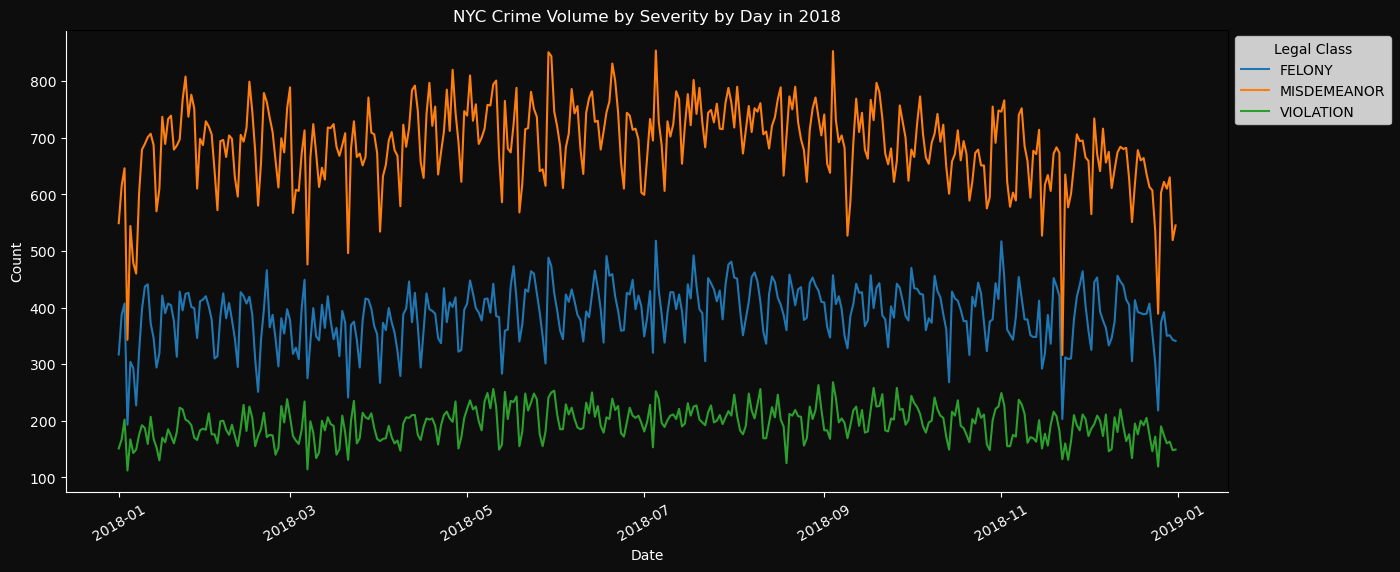

In [39]:
by_severity_H = crime_df[['report_date', 'idx', 'crime_degree']].groupby(['crime_degree','report_date']).count().unstack('crime_degree')
by_severity_H.columns = by_severity_H.columns.droplevel()
ax = by_severity_H.plot()
ax.set_facecolor("#0d0d0d")
fig = ax.get_figure()
fig.set_facecolor("#0d0d0d")
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')

# Other customizations with white for inverted theme
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.title.set_color('white')
ax.tick_params(axis='x', colors='white', rotation=30)
ax.tick_params(axis='y', colors='white')
ax.set_title("NYC Crime Volume by Severity by Day in 2018")
ax.set_xlabel("Date")
ax.set_ylabel("Count")
leg=ax.legend(title="Legal Class", bbox_to_anchor=[1,1],)
fig.set_size_inches((15,6))
fig.savefig('../plots/crime_vol_severity_2018.svg', bbox_inches='tight')

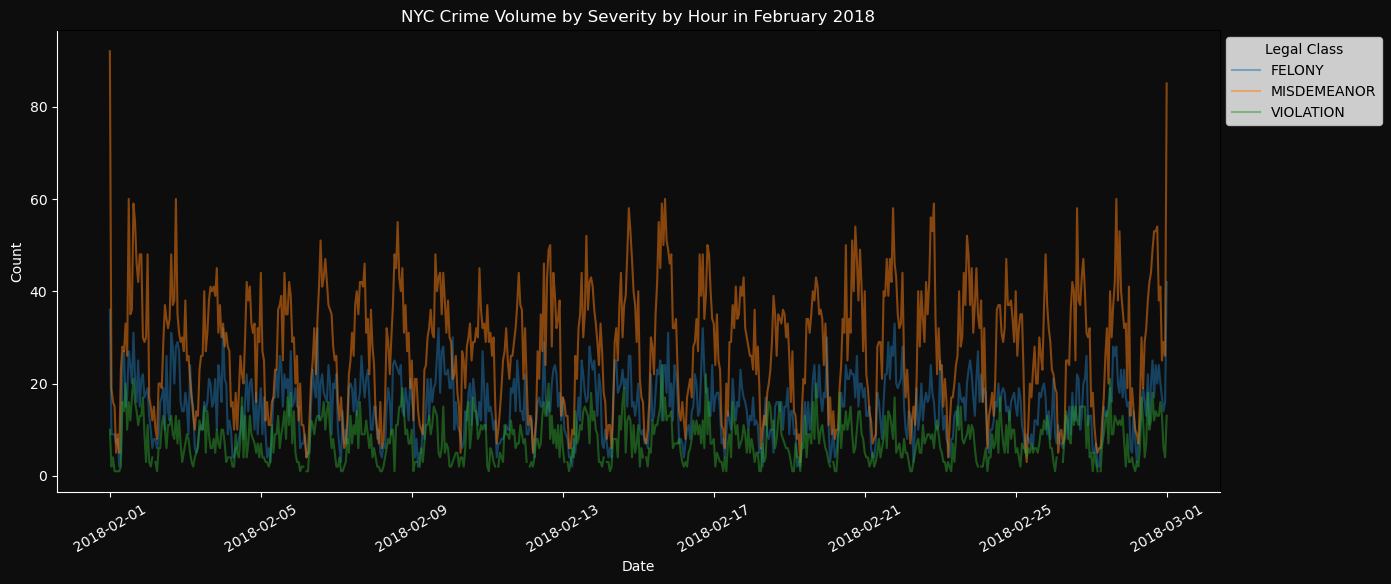

In [52]:
crime_df['crime_H'] = crime_df['crime_date'].dt.round('H')
cdf = crime_df[(crime_df['crime_H']>=datetime.date(2018, 2, 1))&(crime_df['crime_H']<=datetime.date(2018, 3, 1))]
by_severity_H = cdf[['crime_H', 'idx', 'crime_degree']].groupby(['crime_degree','crime_H']).count().unstack('crime_degree')
by_severity_H.columns = by_severity_H.columns.droplevel()
ax = by_severity_H.plot(alpha=0.5)
ax.set_facecolor("#0d0d0d")
fig = ax.get_figure()
fig.set_facecolor("#0d0d0d")
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')

# Other customizations with white for inverted theme
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.title.set_color('white')
ax.tick_params(axis='x', colors='white', rotation=30)
ax.tick_params(axis='y', colors='white')
ax.set_title("NYC Crime Volume by Severity by Hour in February 2018")
ax.set_xlabel("Date")
ax.set_ylabel("Count")
leg=ax.legend(title="Legal Class", bbox_to_anchor=[1,1],)
fig.set_size_inches((15,6))
fig.savefig('../plots/crime_volH_severity_2018.svg', bbox_inches='tight')

In [37]:
crime_df

,idx,report_date,latitude,longitude,general_code,specific_code,attempted,crime_degree,borough,relative_loc,...,housing_code,suspect_age,suspect_race,suspect_sex,victim_age,victim_race,victim_sex,crime_close_date,crime_date,precinct
0,188582344,2018-10-10 00:00:00,40.714534,-74.015669,109,424,COMPLETED,FELONY,MANHATTAN,INSIDE,...,(null),(null),(null),(null),UNKNOWN,UNKNOWN,D,2018-05-01 18:14:00,2018-05-01 15:23:00,1
1,178171483,2018-04-14 00:00:00,40.710086,-74.010609,109,433,COMPLETED,FELONY,MANHATTAN,INSIDE,...,(null),18-24,WHITE,M,UNKNOWN,UNKNOWN,D,2018-04-14 16:20:00,2018-04-14 15:50:00,1
2,191239180,2018-12-17 00:00:00,40.701505,-74.012551,109,439,COMPLETED,FELONY,MANHATTAN,(null),...,(null),UNKNOWN,UNKNOWN,U,45-64,BLACK,M,2018-12-17 08:30:00,2018-12-17 07:30:00,1
3,190596318,2018-11-30 00:00:00,40.710086,-74.010609,341,333,COMPLETED,MISDEMEANOR,MANHATTAN,INSIDE,...,(null),25-44,ASIAN / PACIFIC ISLANDER,F,UNKNOWN,UNKNOWN,D,<NA>,2018-11-30 19:15:00,1
4,173906286,2018-01-22 00:00:00,40.710824,-74.016084,341,321,COMPLETED,MISDEMEANOR,MANHATTAN,INSIDE,...,(null),(null),(null),(null),65+,WHITE HISPANIC,F,2017-11-30 08:00:00,2017-11-29 17:00:00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
464133,188070775,2018-09-26 00:00:00,40.724684,-73.931943,348,916,COMPLETED,MISDEMEANOR,BROOKLYN,FRONT OF,...,(null),(null),(null),(null),25-44,ASIAN / PACIFIC ISLANDER,M,2018-09-26 17:58:00,2018-09-26 17:56:00,94
464134,189217123,2018-10-25 00:00:00,40.718531,-73.929683,578,638,COMPLETED,VIOLATION,BROOKLYN,INSIDE,...,(null),UNKNOWN,BLACK,M,25-44,BLACK,M,2018-10-25 09:00:00,2018-10-25 08:50:00,94
464135,189497884,2018-11-01 00:00:00,40.718531,-73.929683,341,349,COMPLETED,MISDEMEANOR,BROOKLYN,INSIDE,...,(null),(null),(null),(null),UNKNOWN,UNKNOWN,D,2018-10-15 12:00:00,2018-10-15 12:00:00,94
464136,184684949,2018-07-02 00:00:00,40.722122,-73.936045,361,639,COMPLETED,MISDEMEANOR,BROOKLYN,INSIDE,...,(null),25-44,WHITE,M,45-64,WHITE,F,2018-07-02 03:16:00,2018-07-02 00:02:00,94


In [49]:
try:
    crime_df = pd.read_parquet(root_dir/'processed')
    if len(crime_df) == 0:
        raise FileNotFoundError
except FileNotFoundError:
    # expect this to run for ~3minutes depending on number of CPU cores
    from src.preprocessing.identify_district import id_sector
    # NOTE: LAT/LON MAY NOT ACCURATELY REFLECT WHERE THE CRIME TOOK PLACE
    # THIS LEADS TO INCONSISTENCIES IN THE SECTOR OF THE CRIME
    id_sector(crime_df, date_range=(2018, 2019), date_col_name='crime_date', inplace=True)
    crime_df.to_parquet(root_dir/'processed', partition_cols=['precinct','sector'])


View progress here http://127.0.0.1:8787/status
